# Gaussian Mixture Model and the EM Algorithm

This script shows how the *Expectation-Maximaisation (EM) Algorithm* can be used to recover the means and covariance matrices from data which is assumed to be generated by a Gaussian-mixture model. 

## Core Problem

The core of problem is that we observe data points $x_i$, but we are not given from which Gaussian they came from. We assume that the data arose from a Gaussian-mixture model, and by using the EM Algorithm, we are able to give predictions for the means of the Gaussians, the mixing coefficients, and the covariance matrices. Thus, the only parameter that we set is the number of Gaussians $k$ which is why the EM algorithm is an example of *unsupervised learning*. We could extend our model to its hierarchical version to infer $k$ itself from the data. However, this is not part of this script.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal
%matplotlib inline

In [2]:
def generate_mixing_coefficients(number):
    a = 1
    pi_v = np.zeros(number)
    for i in range(number-1):
        pi_v[i] = np.random.uniform(0, a)
        a = a - pi_v[i]
    pi_v[number-1] = a
    return pi_v

num_gaussian = 7
pi_v = generate_mixing_coefficients(num_gaussian)
sigma_v = np.zeros((num_gaussian,2,2))
sigma_v[:, 0, 0] = np.random.uniform(1, 4, size=num_gaussian)
sigma_v[:, 1, 1] = np.random.uniform(1, 4, size=num_gaussian)
sigma_v[:, 0, 1] = np.random.normal(0, 1, size=num_gaussian)
sigma_v[:, 1, 0] = sigma_v[:, 0, 1]

mean_v = np.random.uniform(-15, 15, size=(num_gaussian, 2))

#samples = np.random.multivariate_normal(mean_v[0], sigma_v[0], size=10)


Now, we can draw samples from the mixture of Gaussians by executing the following procedure for each sample:
1. Draw $\pi_k$ from the Categorical distribution conditioned on the vector $\mathbf{\pi_v}$ which are the mixing coefficients
2. Draw a sample x from the k-th Gaussian, $x \sim \mathcal{N}(\mu_k,\,\Sigma_k)$ 

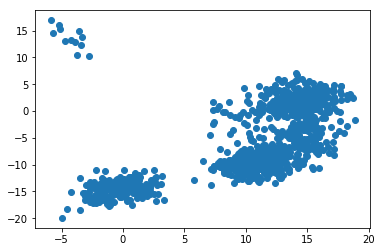

In [3]:
num_samples = 1000
samples = np.zeros((num_samples, 2))
p = np.random.multinomial(num_samples, pi_v)
samples[:p[0],:] = np.random.multivariate_normal(mean_v[0], sigma_v[0], size=p[0])
for i in range(1, num_gaussian, 1):
    samples[np.sum(p[:i]):np.sum(p[:i+1]),:] = np.random.multivariate_normal(mean_v[i], sigma_v[i], size=p[i])
plt.scatter(samples[:, 0], samples[:, 1])

## EM Algorithm

We only use our set of samples and use the EM algorithm to recover the mixing coefficients, covariance matrices, and means of the set of Gaussians.

In [4]:
# First, we initialise the values
mean_em = samples[np.random.randint(low=0, high=num_samples, size=num_gaussian),:]
sigma_em = np.array([np.identity(2)]*num_gaussian)
pi_em = np.zeros(num_gaussian)
a = 1
for i in range(num_gaussian-1):
    pi_em[i] = np.random.uniform(0, a)
    a -= pi_em[i]
pi_em[num_gaussian-1] = a
gamma = np.zeros((num_samples, num_gaussian))

In [5]:
def log_likelyhood(x, mean_em, sigma_em, pi_em):
    s = np.sum([np.log(np.sum([pi_em[k]*multivariate_normal.pdf(x_i, mean=mean_em[k,:], cov=sigma_em[k,:,:]) for k in range(num_gaussian)])) for x_i in x])
    return s

In [6]:
epo = 1
log_l = np.array([log_likelyhood(samples, mean_em, sigma_em, pi_em)])
dif = 100
while (dif > 1 or epo>30):
    # E step
    for n in range(num_samples):
        s = np.sum([pi_em[k]*multivariate_normal.pdf(samples[n,:], mean=mean_em[k,:], cov=sigma_em[k,:,:]) for k in range(num_gaussian)])
        for k in range(num_gaussian):
            gamma[n, k] = pi_em[k]*multivariate_normal.pdf(samples[n,:], mean=mean_em[k,:], cov=sigma_em[k,:,:])/s
            
    # M Step
    N_k = [np.sum([gamma[n, k] for n in range(num_samples)]) for k in range(num_gaussian)]
    mean_em = np.array([np.sum([gamma[n, k]*samples[n,:] for n in range(num_samples)], axis=0)/N_k[k] for k in range(num_gaussian)])
    sigma_em = np.array([np.sum([gamma[n,k]*np.outer(samples[n,:]-mean_em[k,:], samples[n,:]-mean_em[k,:]) for n in range(num_samples)], axis=0)/N_k[k] for k in range(num_gaussian)])
    pi_em = np.array([N_k[k]/num_samples for k in range(num_gaussian)])
    
    # Check Convergence criterium
    log_l = np.append(log_l, log_likelyhood(samples, mean_em, sigma_em, pi_em))
    dif = log_l[len(log_l)-1] - log_l[-2:-1]
    print("Run", epo, 'done with log likelyhood:', log_l[len(log_l)-1])
    epo += 1



Run 1 done with log likelyhood: -5512.281855058112
Run 2 done with log likelyhood: -5501.8419317933885
Run 3 done with log likelyhood: -5493.941173120356
Run 4 done with log likelyhood: -5488.120965751255
Run 5 done with log likelyhood: -5484.516817847722
Run 6 done with log likelyhood: -5482.348224102147
Run 7 done with log likelyhood: -5480.721594179972
Run 8 done with log likelyhood: -5479.309444203463
Run 9 done with log likelyhood: -5478.139923970906
Run 10 done with log likelyhood: -5477.1823090387115


## Results

Let's have a look at the means that the EM-algorithm recovered (in red).

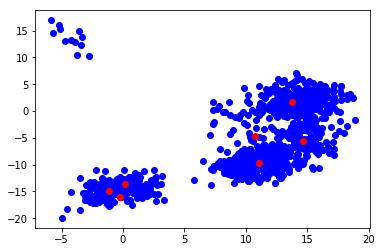

In [7]:
plt.scatter(samples[:,0],samples[:,1],color='blue')
plt.scatter(mean_em[:,0], mean_em[:,1],color='red')
plt.show()